In [1]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import jaxgp.regression as gpr
from jaxgp.kernels import RBF, Linear
import time

import testfunctions
from jaxgp.utils import Logger

### 1D

In [2]:
# from jax import vmap, jit, grad
# sigma = 0.15

# def f(x):
#     return jnp.exp(-(x / sigma)**2) + 0.5*jnp.exp(-0.5*((x-0.5) / sigma)**2)

# def df(x):
#     return (-2*x*jnp.exp(-(x / sigma)**2) + -0.5*(x-0.5)*jnp.exp(-0.5*((x-0.5) / sigma)**2))/(sigma**2)

In [3]:
# seed = 0

# noise = 0.1
# ranges = jnp.array([0.0, 1.0])
# num_datapoints = 1000
# X_train = jnp.linspace(*ranges, num_datapoints).reshape(-1,1)
# y = f(X_train)
# dy = df(X_train)
# Y_train = jnp.hstack((y, dy))

# iters_per_optimizer = 1

# function_set_sizes = [1,]
# # derivative_set_sizes = [2,5,7,10,12,15,20, 100]
# derivative_set_sizes = [10,]

# kernel = RBF()
# param_shape = (2,)
# param_bounds = (1e-3, 10.0)

# grid = jnp.linspace(0,1,100).reshape(-1,1)

In [4]:
# # key = random.PRNGKey(int(time.time()))
# key = random.PRNGKey(0)

# means = []
# stds = []

# for fun_vals in function_set_sizes:
#     for der_vals in derivative_set_sizes:
#         # logger for each pair of function vals and derivative vals
#         logger = Logger(f"f{fun_vals}d{der_vals}")

#         key, subkey = random.split(key)
#         fun_perm = random.permutation(subkey, num_datapoints)[:fun_vals]
#         key, subkey = random.split(key)
#         d1_perm = random.permutation(subkey, num_datapoints)[:der_vals]

#         X_fun = X_train[fun_perm]
#         Y_fun = Y_train[fun_perm,0]
#         X_d1 = X_train[d1_perm]
#         Y_d1 = Y_train[d1_perm,1]

#         X = jnp.vstack((X_fun, X_d1))
#         Y = jnp.hstack((Y_fun, Y_d1))
#         data_split = jnp.array([fun_vals, der_vals])

#         for i in range(iters_per_optimizer):
#             key, subkey = random.split(key)
#             init_params = random.uniform(subkey, param_shape, minval=param_bounds[0], maxval=param_bounds[1])
#             logger.log(f"# iter {i+1}: init params {init_params}")

#             model = gpr.ExactGPR(kernel, init_params, noise, logger=logger)
#             model.train(X, Y, data_split=data_split)
#             m, s = model.eval(grid)
#             means.append(m)
#             stds.append(s)

In [5]:
# plt.plot(X_train, Y_train[:,0])
# for der,mean in zip(derivative_set_sizes,means):
#     plt.plot(grid, mean, label=f"{der} der obs")

# plt.grid()
# plt.legend()

### 2D

In [6]:
def function(x):
    return jnp.sin(2*x[0] + x[1])

In [7]:
optimizers = ["L-BFGS-B", "TNC", "SLSQP"]#, "Nelder-Mead", "Powell", "trust-constr"]

seed = 0
num_gridpoints = jnp.array([100,100])
num_datapoints = jnp.prod(num_gridpoints)
noise = 0.1
# ranges = (jnp.array([0,2*jnp.pi]),jnp.array([0,2*jnp.pi]))
# ranges = (jnp.array([0.0,1.0]), jnp.array([0.0,1.0]))
ranges = (jnp.array([-10.0,10.0]), jnp.array([-10.0,10.0]))
fun = testfunctions.easom
# fun = function

X_train, Y_train = testfunctions.create_training_data_2D(seed, num_gridpoints, ranges, noise, fun)
# X_train, Y_train = make_unique(X_train, Y_train)

iters_per_optimizer = 5

# function_set_sizes = [20,]
# derivative_set_sizes = [100,]
num_f_vals = 20
num_d_vals = 100

kernel = RBF(3)
param_shape = (3,)
param_bounds = (1e-3, 10.0)

grid1 = jnp.linspace(*ranges[0],100)
grid2 = jnp.linspace(*ranges[1],100)
grid = jnp.array(jnp.meshgrid(grid1, grid1)).reshape(2,-1).T

In [8]:
log_dict = {}

names = ["franke", "himmelblau", "easom", "ackley", "sin"]
functions = [testfunctions.franke, testfunctions.himmelblau, testfunctions.easom, testfunctions.ackley, function]
ranges = [(jnp.array([0.0,1.0]), jnp.array([0.0,1.0])), 
          (jnp.array([-5.0,5.0]), jnp.array([-5.0,5.0])),
          (jnp.array([-10.0,10.0]), jnp.array([-10.0,10.0])),
          (jnp.array([-5.0,5.0]), jnp.array([-5.0,5.0])),
          (jnp.array([0.0,2*jnp.pi]), jnp.array([0.0,2*jnp.pi]))]

for fun, ran, name in zip(functions, ranges, names):
    X_train, Y_train = testfunctions.create_training_data_2D(seed, num_gridpoints, ran, noise, fun)

    log_dict[name] = {}

    for optimizer in optimizers:
        print(f"Optimizer {optimizer}")
        logger = Logger(optimizer)

        means, stds = testfunctions.test_optimizer(X_train=X_train, Y_train=Y_train, num_f_vals=num_f_vals, num_d_vals=num_d_vals,
                                                logger=logger, kernel=kernel, param_bounds=param_bounds, param_shape=param_shape, noise=noise, optimizer=optimizer,
                                                iters=iters_per_optimizer, evalgrid=grid, seed=int(time.time()))
        
        jnp.savez(f"./prediction_files/{name}means{optimizer}", *means)
        jnp.savez(f"./prediction_files/{name}std{optimizer}", *stds)
        log_dict[name][optimizer] = logger.iters_list

Optimizer L-BFGS-B
OptStep(params=DeviceArray([2.5785234 , 0.19087727, 9.847868  ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(nan, dtype=float32, weak_type=True), success=False, status=2, iter_num=3))
OptStep(params=DeviceArray([1.6674480e+01, 3.8448040e+00, 4.3957513e-03], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.04288135, dtype=float32, weak_type=True), success=False, status=2, iter_num=4))
OptStep(params=DeviceArray([5.33071   , 0.25889212, 0.28406152], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.00769728, dtype=float32, weak_type=True), success=True, status=0, iter_num=3))
OptStep(params=DeviceArray([7.2952037 , 2.5956926 , 0.00810629], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.04288135, dtype=float32, weak_type=True), success=False, status=2, iter_num=3))
OptStep(params=DeviceArray([9.332259  , 0.22247681, 5.3838544 ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(nan, dtype=float32, weak_t

/home/lukas/miniconda3/envs/gpr/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


OptStep(params=DeviceArray([35.602722  ,  0.29179013,  0.32389456], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.00523747, dtype=float32, weak_type=True), success=True, status=0, iter_num=27))


/home/lukas/miniconda3/envs/gpr/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


OptStep(params=DeviceArray([6.9703603, 0.2647971, 0.2926795], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.0066677, dtype=float32, weak_type=True), success=True, status=0, iter_num=17))
OptStep(params=DeviceArray([8.335126  , 0.26877102, 0.2968725 ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.00651614, dtype=float32, weak_type=True), success=True, status=0, iter_num=13))


/home/lukas/miniconda3/envs/gpr/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


OptStep(params=DeviceArray([9.2241211e+00, 6.4953718e+00, 1.0415661e-03], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(nan, dtype=float32, weak_type=True), success=False, status=5, iter_num=8))


/home/lukas/miniconda3/envs/gpr/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


OptStep(params=DeviceArray([1.3904447e+01, 1.4240475e+00, 1.1542806e-03], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.04759384, dtype=float32, weak_type=True), success=True, status=0, iter_num=35))
Optimizer L-BFGS-B
OptStep(params=DeviceArray([3.9300039e+04, 1.9133825e+00, 1.7792225e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.02259879, dtype=float32, weak_type=True), success=True, status=0, iter_num=45))
OptStep(params=DeviceArray([3.7392465e+04, 1.8879951e+00, 1.7356806e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(1839.8052, dtype=float32, weak_type=True), success=False, status=2, iter_num=47))
OptStep(params=DeviceArray([3.9675902e+04, 1.9322805e+00, 1.8654354e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.02303417, dtype=float32, weak_type=True), success=True, status=0, iter_num=44))
OptStep(params=DeviceArray([4.5022598e+04, 2.0201643e+00, 1.7197578e+00], dtype=float32), state=ScipyMinimizeInfo(fun

/home/lukas/miniconda3/envs/gpr/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


OptStep(params=DeviceArray([4.3589250e+04, 1.9451047e+00, 1.8775799e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.02713756, dtype=float32, weak_type=True), success=True, status=0, iter_num=63))
OptStep(params=DeviceArray([7.8941909e+03, 1.4872869e+00, 9.3453419e-01], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.04953266, dtype=float32, weak_type=True), success=True, status=0, iter_num=50))
OptStep(params=DeviceArray([4.0807938e+04, 1.7037868e+00, 1.6513672e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.02699636, dtype=float32, weak_type=True), success=True, status=0, iter_num=61))


/home/lukas/miniconda3/envs/gpr/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


OptStep(params=DeviceArray([3.3448062e+04, 2.0250490e+00, 1.7714679e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.03034214, dtype=float32, weak_type=True), success=True, status=0, iter_num=61))


/home/lukas/miniconda3/envs/gpr/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


OptStep(params=DeviceArray([2.8899617e+04, 1.4387120e+00, 1.8033046e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.03101959, dtype=float32, weak_type=True), success=True, status=0, iter_num=49))
Optimizer L-BFGS-B
OptStep(params=DeviceArray([1.0000000e-03, 1.2542922e+01, 1.3687934e+01], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.01947524, dtype=float32, weak_type=True), success=True, status=0, iter_num=2))
OptStep(params=DeviceArray([1.0000000e-03, 1.4876664e+01, 1.7322828e+01], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.01947638, dtype=float32, weak_type=True), success=True, status=0, iter_num=5))
OptStep(params=DeviceArray([1.0000000e-03, 1.5993348e+01, 1.3142067e+01], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.01947742, dtype=float32, weak_type=True), success=True, status=0, iter_num=6))
OptStep(params=DeviceArray([1.0000000e-03, 1.3602646e+01, 1.0580169e+01], dtype=float32), state=ScipyMinimizeInfo(fun

/home/lukas/miniconda3/envs/gpr/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


OptStep(params=DeviceArray([5.4677520e+00, 3.7830917e-03, 4.0537810e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(nan, dtype=float32, weak_type=True), success=False, status=5, iter_num=6))
OptStep(params=DeviceArray([8.606932  , 0.43384108, 0.43289024], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.02640835, dtype=float32, weak_type=True), success=True, status=0, iter_num=16))
Optimizer L-BFGS-B
OptStep(params=DeviceArray([3.451057 , 1.0369728, 1.9948887], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.01255879, dtype=float32, weak_type=True), success=True, status=0, iter_num=28))
OptStep(params=DeviceArray([6.9718456, 1.1301186, 2.1355572], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.01249889, dtype=float32, weak_type=True), success=True, status=0, iter_num=14))
OptStep(params=DeviceArray([3.307057 , 1.0306666, 1.9868425], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.01255854, dtype=float32, weak_

/home/lukas/miniconda3/envs/gpr/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


OptStep(params=DeviceArray([1.5181316, 0.9568531, 1.7020385], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.01153281, dtype=float32, weak_type=True), success=True, status=0, iter_num=21))


In [9]:
# means = mean_dict["SLSQP"]
# plt.pcolormesh(grid1, grid2, means[0].reshape(len(grid1), len(grid2)))
# plt.colorbar()

In [10]:
# plt.pcolormesh(grid1, grid2, Y_train[:,0].reshape(100,100))# - means[0].reshape(len(grid1), len(grid2)))
# plt.colorbar()

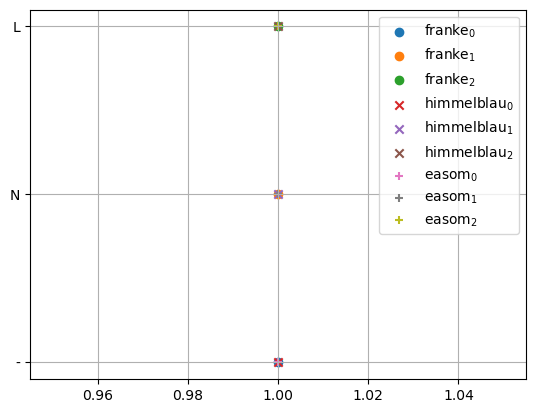

In [11]:
markers = ["o", "x", "+"]

for marker, (key, value) in zip(markers,log_dict.items()):
    for i,elem in enumerate(value):
        nums = jnp.arange(1,len(elem[1])+1)
        plt.scatter(nums, elem[1],label=f"{key}$_{i}$", marker=marker)

plt.legend()
plt.grid()